# Chapter 9: Variational Autoencoders




So far, we have learned how to generate figures, patterns, and images, all based on generative adversarial networks (GANs). In this chapter, we'll discuss another type of generative models: variational autoencoders (VAEs). The model consists of two parts: an encoder and a decoder. The encoder compresses the data to the latent space, and the decoder decompresses the encoded information and reconstructs the image. One key feature of variational autoencoders is that they ar probabilistic autoencoders. This means that the output is partly determined by chance and the model can produce instances that are not in the training dataset. 

We'll use the Fashion MNIST data that we have seen in Chapter 5 to illustrate how VAEs work. In particular, the model assumes that the training samples follow a normal distribution and observations are independent from each other. At the same time, the means and standard deviations of the ten types of clothes items in the Fashion MNIST dataset are different from each other. When training the model, we'll learn the mean and distribution of each type of the clothes items. Based on the mean and standard deviation learned by the encoder, we can use the decoder to reconstruct each type of clothes items that look like they come from the training set. 

Start a new cell in ch09.ipynb and execute the following lines of code in it:

In [1]:
import os

os.makedirs("files/ch09", exist_ok=True)

# 1. Theoretical Background
Variational autoencoders (VAEs) are proposed by Diederik Kingma and Max Welling in 2013. Similar to other types of autoencoders, VAEs consist of an encoder and a decoder. The encoder decompresses information in inputs to a lower dimensional space. Therefore, it maps the inputs to a latent space the represents the distribution of the inputs. The decoder, on the other hand, decompresses information from the latent space and produces probabilistic samples that resemble the inputs. 

The encoder is trying to learn the true distribution of the training data $x$, $p(x|\theta)$. For tractability, we assume that the distribution is normal (that is, a Gaussian distribution): that is, $p(x|\theta)=p(x|\mu,\sigma)$ since we only need the mean and standard deviation to capture a normal distribution. Further, we assume that the samples are independent from each other, and this is equivalent to assuming that the covariance matrix $\sigma$ is diagonal: all values off diagonal are zero since the correlation between any two different samples is zero.  

The decoder generates a sample based on the distribution learned by the encoder. Since we have assumed an independent normal distribution, the decoder generates an instance probabilistically from the distribution $p(x|\mu,\sigma)$.  

When training the model, we use a loss function that consists of two parts: the reconstruction error and the Kullback-Leibler (KL) divergence. We use binary cross-entropy to measure the reconstruction error between the original sample and the reconstructed sample. The KL divergence is calculated as follows:
$$kl=-\frac{1}{2}\Sigma_{n=1}^N[1+log(\sigma_n^2)-\mu_n^2-\sigma_n^2]$$

# 2.  A Variational Autoencoder to Generate Clothes Items
Our goal is to train a variational autoencoder to generate gray-scale images of clothes items such as sandals, t-shirts, coats and bags. As we did in Chapter 5, we first preprocess the training data, and put them in batches for training later. 

## 2.1. Preprocess the Training Data
You can download the Fashion MNIST data directly from Torchvision datasets, as you did in Chapers 2 and 5. 

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

transform=T.Compose([
    T.ToTensor(),
    T.Normalize([0.5],[0.5])])
train_set=torchvision.datasets.FashionMNIST(root=r"C:\temp",
    train=True,download=True,transform=transform) 
test_set=torchvision.datasets.FashionMNIST(root=r"C:\temp",
    train=False,download=True,transform=transform) 

Before transformation, the image data are integers ranging from 0 to 255. We convert them to PyTorch float tensors with values between -1 to 1. There are ten different types of clothes items, with labels from 0 to 9. To convert integer labels to text labels, we define a list *names* as follows:

In [3]:
names=['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
       'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

We'll create batches of data for training. There are 60,000 images in the training set and we create batches with 32 items in each batch. 

In [4]:
batch_size=32
train_loader=torch.utils.data.DataLoader(
    train_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(
    train_set,batch_size=batch_size,shuffle=True)

## 2.2. The Autoencoder
The autoencoder consists of two parts: the encoder and the decoder. We'll define a *VAE()* class as follows to represent the autoencoder:

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# determine the device automatically
device="cuda" if torch.cuda.is_available() else "cpu"
input_dim = 784
z_dim = 20
h_dim = 200
class VAE(nn.Module):
    def __init__(self,input_dim,z_dim,h_dim):
        super().__init__()
        self.common = nn.Linear(input_dim, h_dim)
        self.encode_mu = nn.Linear(h_dim, z_dim)
        self.encode_std = nn.Linear(h_dim, z_dim)
        self.l1 = nn.Linear(z_dim, h_dim)
        self.decode = nn.Linear(h_dim, input_dim)        
           
    def encoder(self, x):
        common = F.relu(self.common(x))
        mu = self.encode_mu(common)
        std = self.encode_std(common)
        return mu,std

    def decoder(self, z):
        out=F.relu(self.l1(z))
        out=torch.sigmoid(self.decode(out))
        return out

    def forward(self, x):
        mu,std=self.encoder(x)
        noise=torch.randn_like(std)
        sample=mu+noise*std
        out=self.decoder(sample)
        return out, mu, std

The input size is 784 because the image is 28 by 28. We flatten the images to one-dimensional tensors and feed them to the model. The image first go through the encoder: the image is decompressed into two values *mu* and *std*. VAEs assume that the true data distribution are Gaussian (i.e., normally distributed). We only need two parameters, the mean value *mu* and the standard deviation *std* to capture all information in a normal distribution. 

The decoder then tries to reconstruct the image based on the outputs *mu* and *std* from the encoder. The output from the decoder has a size of 784 with values between -1 and 1. We'll later reshape the output into a 28 by 28 gray-scale image.  

Next, we initialize the VAE model as follows:

In [6]:
model = VAE(input_dim,z_dim,h_dim).to(device)

## 2.3.  The Loss Function and Optimizer

We'll use the binary cross-entropy loss to calculate the reconstruction loss. We'll add in the KL-divergence to the total loss during training. We'll use the Adam optimizer for the model:

In [7]:
loss_fn=nn.BCELoss()
lr=0.00025
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss(reduction="sum")

# 3. Train the Variational Autoencoder
To train the autoencoder, we'll use clothes items as inputs and the reconstructed images of the same clothes item as outputs. The model adjusts the parameters to minimize the sum of the reconstruction loss and the KL-divergence. 

## 3.1. Visualize Ouputs Periodically
We define a function *test()* to visualize the reconstructed clothes items after each epoch of training, as follows: 

In [8]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# collect a sample for each clothes item
originals = []
idx = 0
for img,label in test_set:
    if label == idx:
        originals.append(img)
        idx += 1
    if idx == 10:
        break

def test():
    reconstructed=[]
    for idx in range(10):
        # encode the cloth item
        with torch.no_grad():
            img = originals[idx].reshape((1,784))
            mu, std = model.encoder(img.to(device))
        # reconstruct the cloth item
        epsilon = torch.randn_like(std)
        z = mu + std * epsilon
        out = model.decoder(z.to(device))
        out = out.reshape(28, 28)
        reconstructed.append(out)
    # Plot both the originals and the reconstructed
    imgs=originals+reconstructed
    plt.figure(figsize=(20,4),dpi=100)
    for i in range(20):
        ax = plt.subplot(2,10, i + 1)
        img=(imgs[i]/2+0.5).detach().cpu().numpy()
        plt.imshow(img.reshape(28,28))
        plt.xticks([])
        plt.yticks([])
    plt.show()    

Before training, the fake samples look as follows:

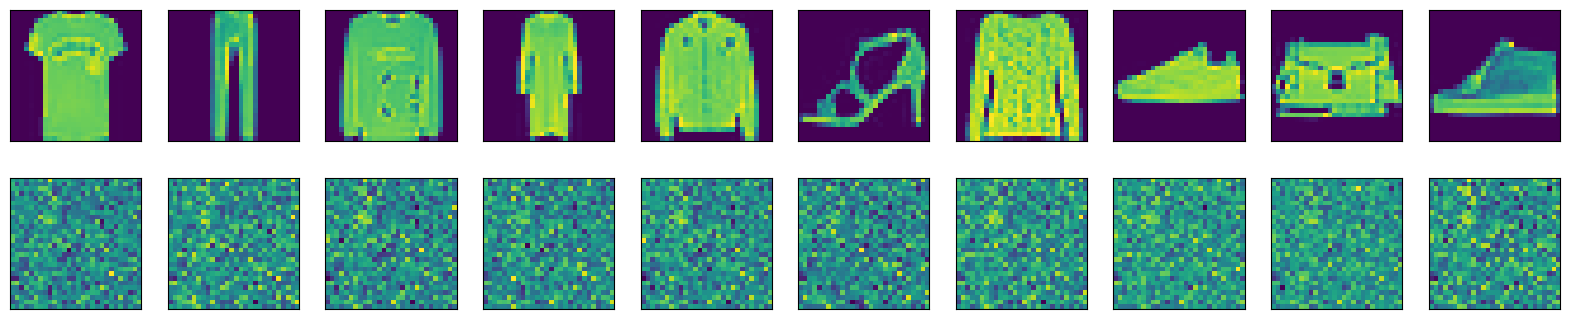

In [9]:
test()

As you can see, before training, the fake images look not at all like clothes items. 

## 3.2. Train the Model
We train the model for ten epochs, as follows:

at epoch 0 toal loss = 35873117.9453125


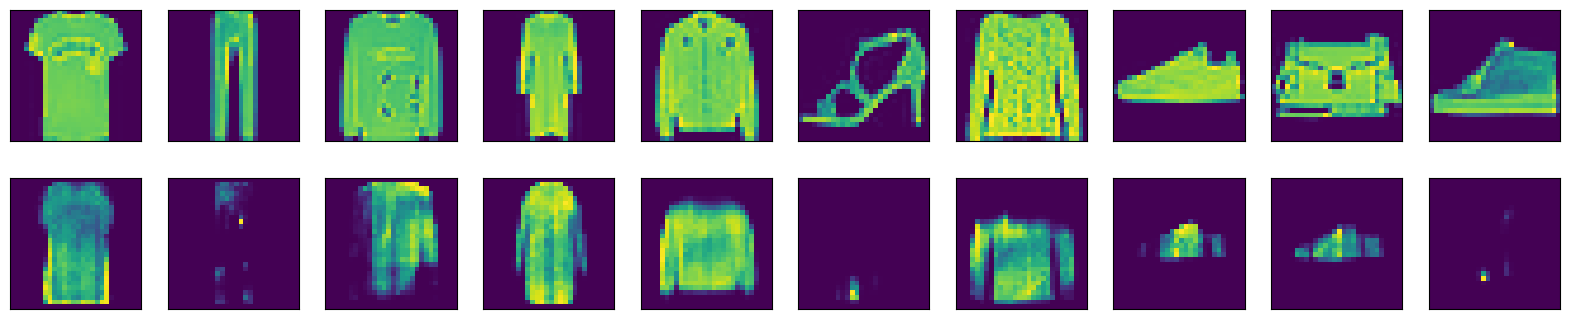

at epoch 1 toal loss = 33433243.153320312


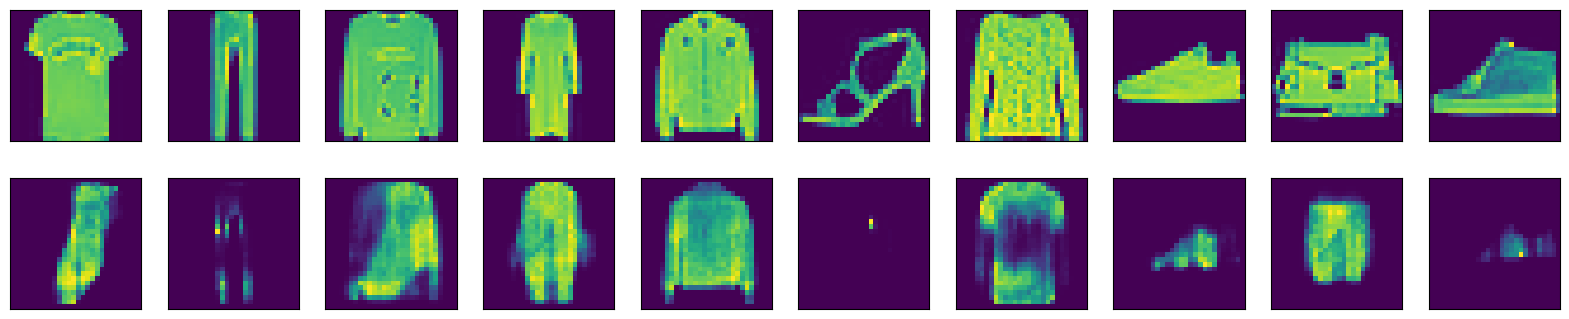

at epoch 2 toal loss = 33667000.857421875


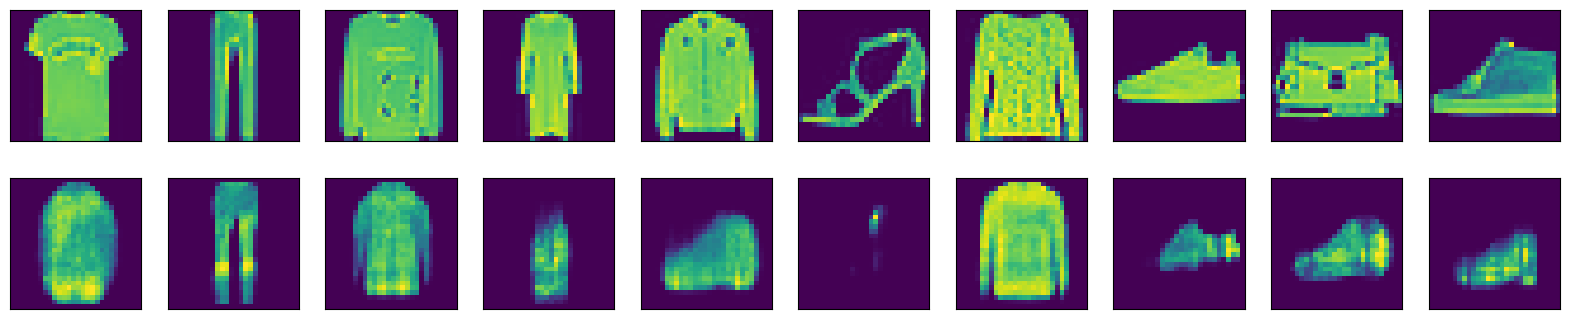

at epoch 3 toal loss = 34878930.525390625


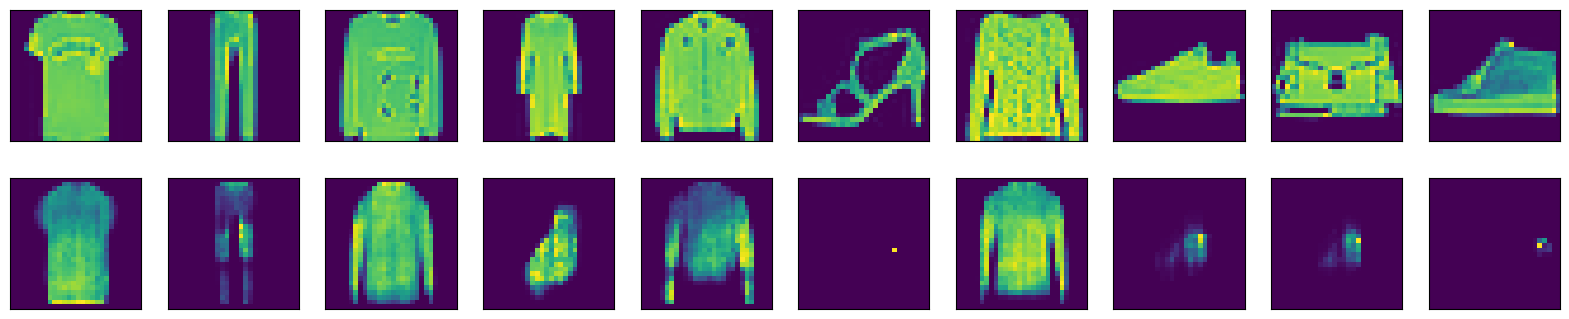

at epoch 4 toal loss = 34727876.78613281


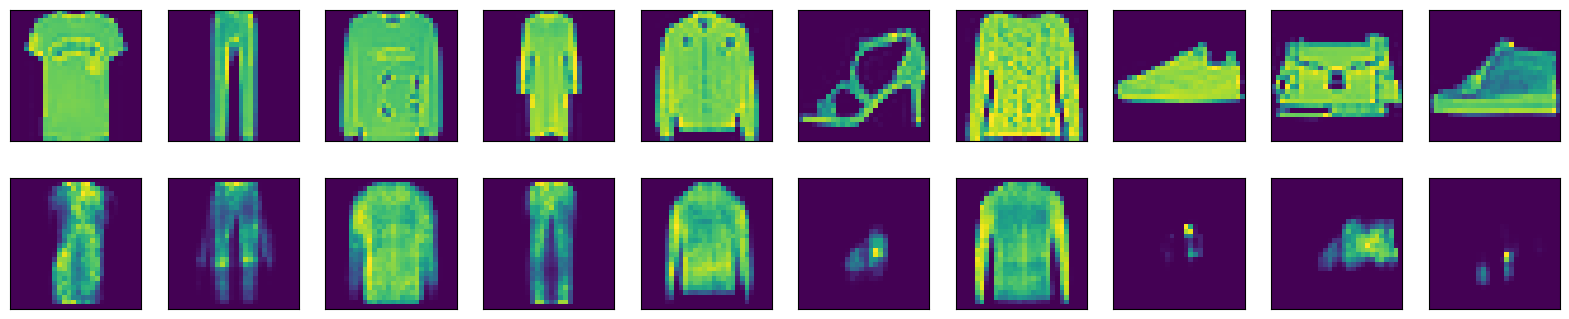

at epoch 5 toal loss = 37266200.88378906


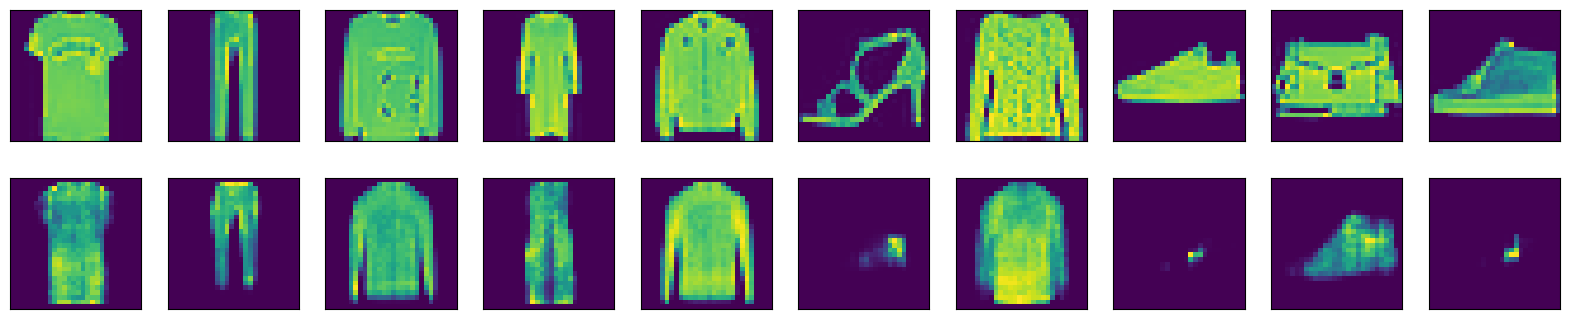

at epoch 6 toal loss = 36327112.38671875


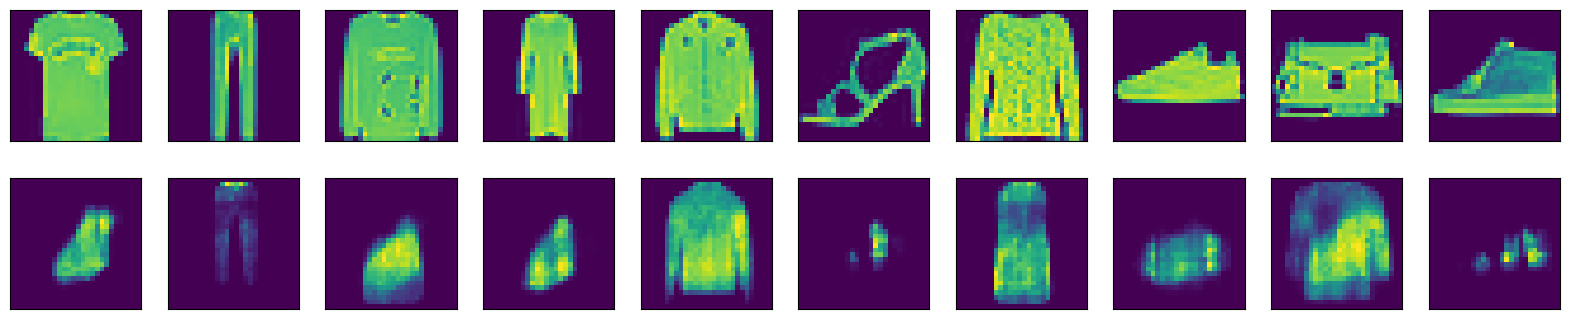

at epoch 7 toal loss = 36661403.56640625


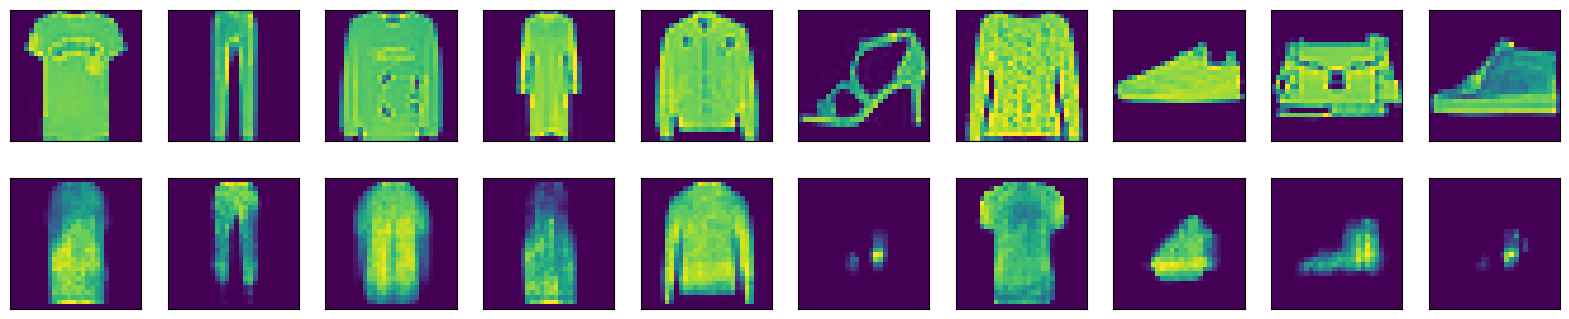

at epoch 8 toal loss = 35412551.11035156


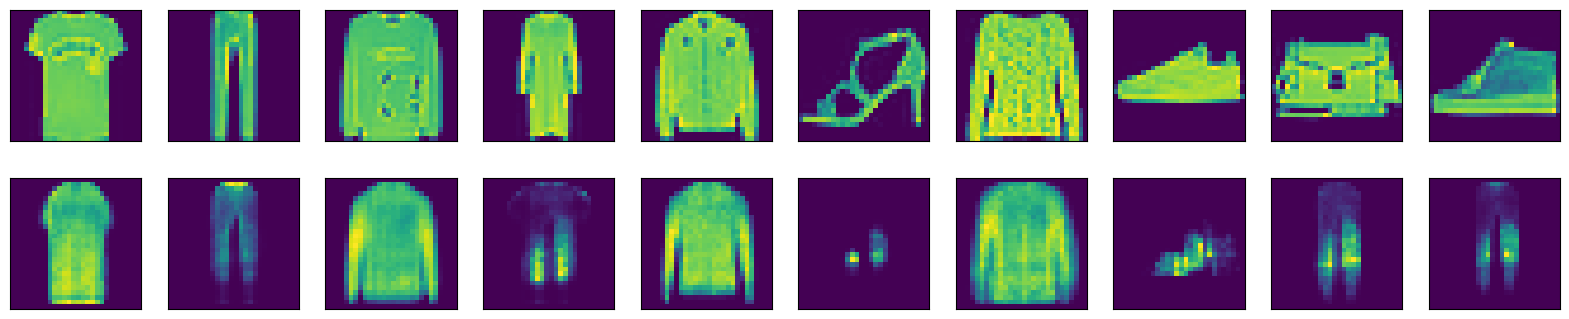

at epoch 9 toal loss = 35393591.595703125


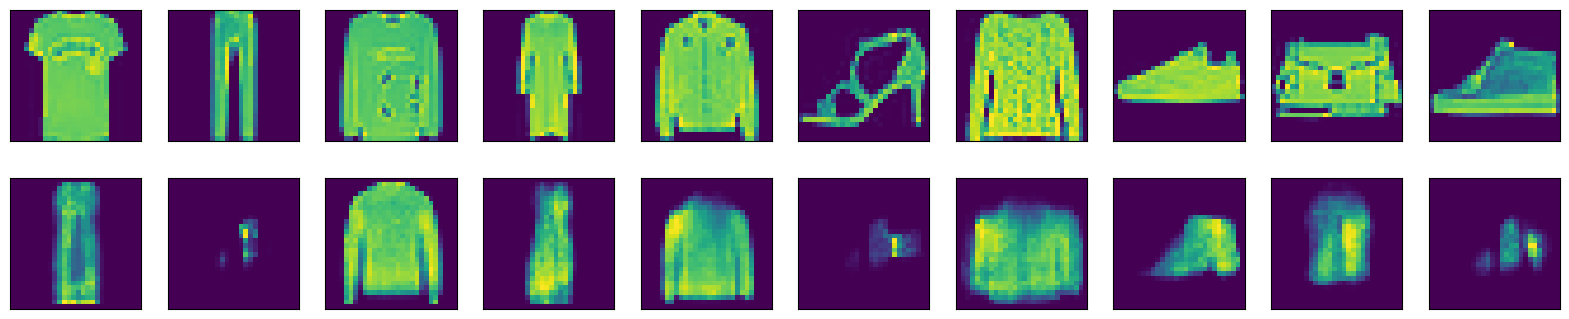

In [10]:
for epoch in range(10):
    tloss=0
    for imgs, labels in train_loader:
        # reconstruct the images
        imgs = imgs.to(device).view(-1, input_dim)
        out, mu, std= model(imgs)
        # calculate the reconstruction loss
        #out_loss = loss_fn(out, imgs)
        out_loss = ((out-imgs)**2).sum()
        # calculate the KL divergence
        kl=-torch.sum(1+torch.log(std.pow(2))-mu.pow(2)-std.pow(2))
        # Backpropagation
        loss=out_loss+kl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tloss+=loss.item()
    print(f"at epoch {epoch} toal loss = {tloss}")
    # visualize the reconstructed clothes items
    test()

In each iteration, we generate a batch of ten numbers. We first train the discriminator using the real samples. After that, the generator creates a batch of fake samples and we use them to train the discriminator D again. Finally, we let the generator create a batch of fake samples again, but we use them to train the generator instead.

After just ten epochs of training, the model can already generate clothes items that are clearly can pass as real: you can clearly tell what they are. The first three items in the first row are clearly a coat, a dress, and a pair of trousers. 

# 4. Save and Use the Autoencoder
We'll save the model in the local folder on your computer, as follows:

In [11]:
# Export to TorchScript
scripted = torch.jit.script(model) 
# Save the model
import os
os.makedirs("files/ch09", exist_ok=True)
scripted.save('files/ch09/fashion_VAE.pt') 

We have now saved the autoencoder to the local folder. To use it to reconstruct a clothes item, we don't even need to redefine the model. We simply load up the model and use it to generate clothes items as follows: 

In [12]:
new_VAE=torch.jit.load('files/ch09/fashion_VAE.pt',map_location=device)
new_VAE.eval()

RecursiveScriptModule(
  original_name=VAE
  (common): RecursiveScriptModule(original_name=Linear)
  (encode_mu): RecursiveScriptModule(original_name=Linear)
  (encode_std): RecursiveScriptModule(original_name=Linear)
  (l1): RecursiveScriptModule(original_name=Linear)
  (decode): RecursiveScriptModule(original_name=Linear)
)

The autoencoder is now reloaded. We can use it to generate clothes items as follows:

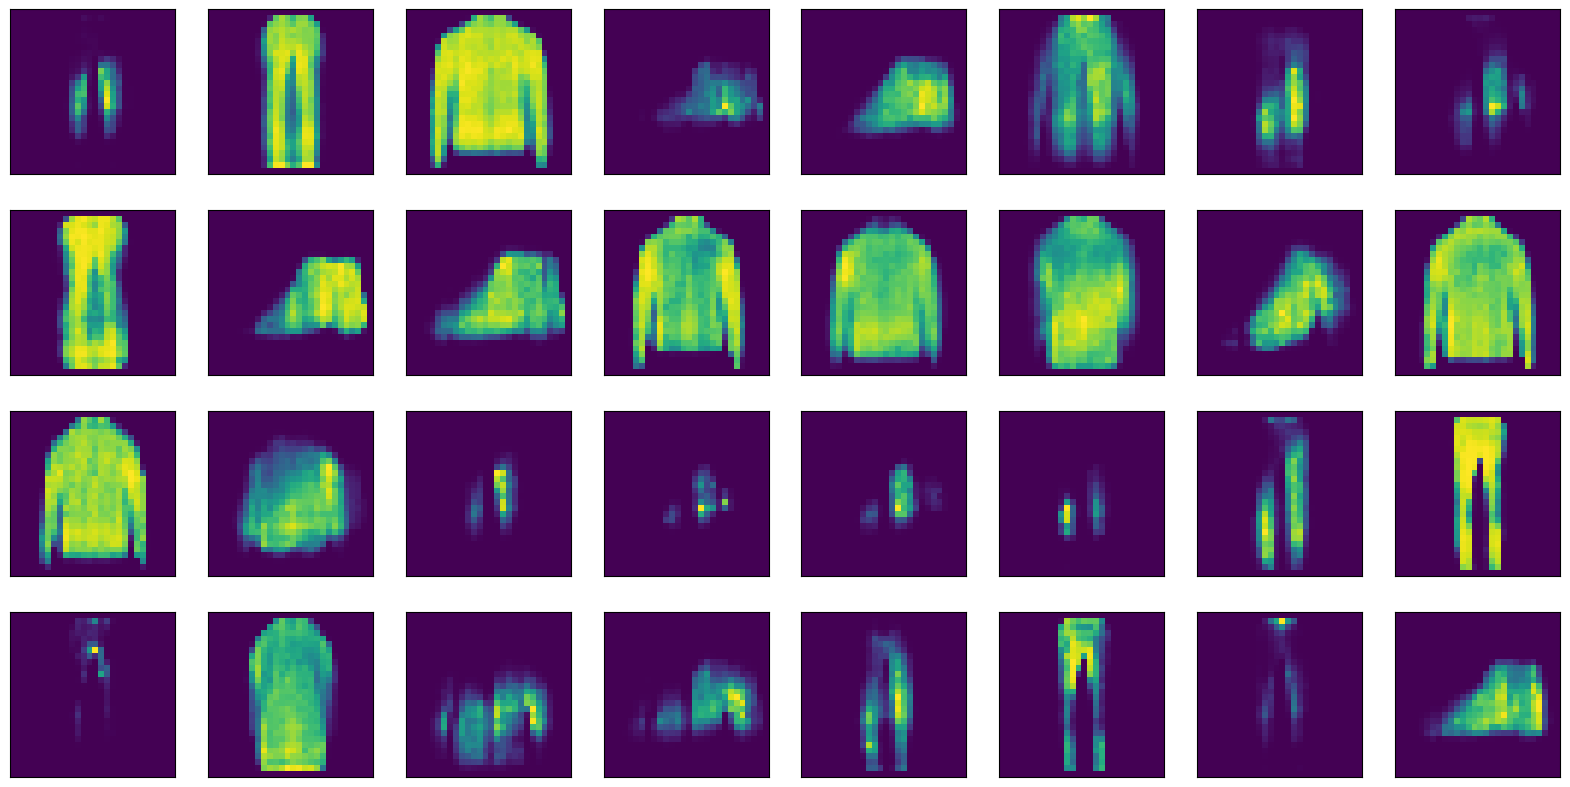

In [13]:
imgs, labels=next(iter(test_loader))
# reconstruct the images
imgs = imgs.to(device).view(-1, input_dim)
out, mu, std=new_VAE(imgs)
reconstructed=out.detach().cpu().numpy()
plt.figure(figsize=(20,10),dpi=100)
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(reconstructed[i]/2+0.5).reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show() 

The reconstructed images are not as realistic as those generated by GAN model in Chapter 5. This is due to the fact that VAEs make fairly strong assumptions: that the true distribution is normal and the observations are independent from each other. However, compared to GANs, variational autoencoders are easy to construct and take less time to train. In the next chapter, we'll add convolutional layers to the model so that VAEs can generate high resolution images. 